In [1]:
import glob
import io
import math
import time
from tqdm import tqdm
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from keras import Sequential, Input, Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing import image
from keras.datasets import mnist
np.random.seed(1337)

In [2]:
def build_generator():
      model = Sequential()
      model.add(Dense(128 * 7 * 7, activation="relu", input_dim= noise_dim))
      model.add(Reshape((7, 7, 128)))
      model.add(UpSampling2D())
      model.add(Conv2D(128, kernel_size=4, padding="same"))

      model.add(Activation("relu"))
      model.add(UpSampling2D())
      model.add(Conv2D(64, kernel_size=4, padding="same"))

      model.add(Activation("relu"))
      model.add(Conv2D(1, kernel_size=4, padding="same"))
      return model


def build_discriminator():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1))
    return model


In [3]:
learning_rate = 0.00005 # alpha
c = 0.01                # clipping parameter
n = 5                   # n_critic
epochs = 50
batch_size = 64
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000     # mnist buffer size

In [4]:
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # image normalization [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)

In [5]:
G = build_generator()
D = build_discriminator()

In [6]:
generator_optimizer = RMSprop(learning_rate)
discriminator_optimizer = RMSprop(learning_rate)

In [7]:
def d_loss(real, fake):
    loss = K.mean(real) - K.mean(fake)
    return loss

def g_loss(fake):
    loss = K.mean(fake)
    return loss

In [8]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [9]:
@tf.function
def train_step(images):
    for i in range(n): # n_critic 번 critic 학습
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as disc_tape:    # tf.GradientTape()을 이용해 gradient 계산
            D.training = True
            
            generated_images = G(noise)         # G로부터 fake data 생성
            real_output = D(images)             # 논문 내 f(x^i)
            fake_output = D(generated_images)   # 논문 내 f(G(z^i))
            disc_loss = -d_loss(real_output, fake_output) # loss 계산
        
        # RMSProp(lr = 0.00005)로 학습 진행
        gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
        
        # weight clipping
        disc_weights = discriminator_optimizer.weights  # get critic weights
        clip_w = [w.assign(tf.clip_by_value(w, -c, c)) for w in disc_weights if w.shape != ()] 
        # tf.clip_by_value를 통해 [-0.01, 0.01]로 clipping
    
    # generator 학습
    with tf.GradientTape() as gen_tape:
        noise = tf.random.normal([batch_size, noise_dim])
        G.training = True

        generated_images = G(noise)             # G로부터 fake data 생성     
        fake_output = D(generated_images)       # 논문 내 f(G(z^i))
        gen_loss = -g_loss(fake_output)          # loss 계산
    
    # RMSProp(lr = 0.00005)로 학습 진행
    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))    
    
    return gen_loss, disc_loss

In [10]:
def train(dataset, epochs):
    noise = tf.random.normal([batch_size, noise_dim])
    generated_images = G(noise)   
    plt.figure(figsize=(5,5))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(generated_images[i][:,:,0],'gray')
        plt.axis('off')
    plt.show()
    for epoch in range(epochs):
        print(epoch)
        start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in train_dataset:
            loss = train_step(image_batch)
            gen_loss_list.append(loss[0])
            disc_loss_list.append(loss[1])
            
        # 이미지 생성 및 저장
        noise = tf.random.normal([batch_size, noise_dim])
        generated_images = G(noise)   
        plt.figure(figsize=(5,5))
        for i in range(1,17):
            plt.subplot(4,4,i)
            plt.imshow(generated_images[i][:,:,0],'gray')
            plt.axis('off')
        plt.show()
        
        print(np.mean(gen_loss_list),np.mean(disc_loss_list))


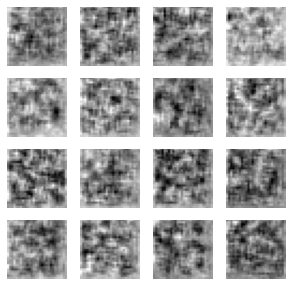

0


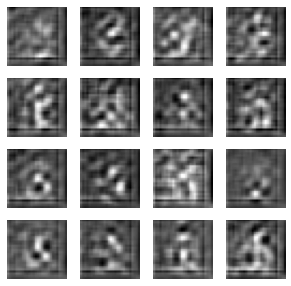

-4638.322 -2828.3489
1


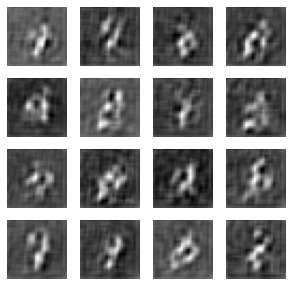

-12730.753 -13476.798
2


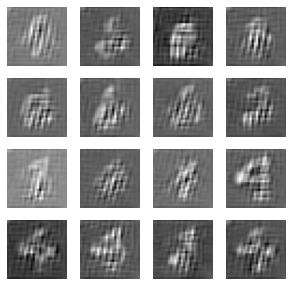

-69654.055 -95922.25
3


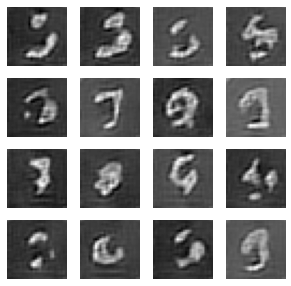

-575812.0 -340270.6
4


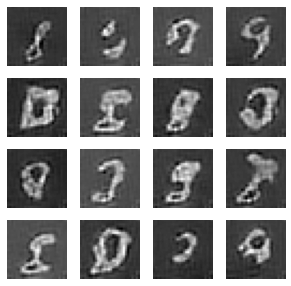

-1587220.6 -449389.28
5


In [ ]:
gen_loss_list,disc_loss_list = train(train_dataset, epochs)